# Introduction
This project aims to build a gender classification model using the VGG16 architecture and transfer learning. Data augmentation, training, and validation generators will be employed. The model's performance will be evaluated through visualizations and sample predictions.

# Importing Libraries

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Defining Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Defining Parameters

In [3]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=3

# Dataset Info
The dataset contains male and females images , already split into train test and validation
ImageDataGenerator effectively handles class labels for image classification by utilizing the flow_from_directory function.

In [4]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( 'Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


# Building Model

In [5]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

In [6]:
for layer in base_model.layers[:fre]:
    layer.trainable=False

In [7]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (Batch  (None, 2, 2, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [8]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [9]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(verbose=verbose, patience=patience)

# Training 

In [10]:
%time
hist = model.fit(train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/3


256/256 [==============================] - 1182s 5s/step - loss: 0.7017 - accuracy: 0.6068 - val_loss: 0.5343 - val_accuracy: 0.7313 - lr: 0.0010
Epoch 2/3
256/256 [==============================] - 1180s 5s/step - loss: 0.5664 - accuracy: 0.7213 - val_loss: 0.8746 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 3/3
256/256 [==============================] - 1170s 5s/step - loss: 0.4568 - accuracy: 0.7913 - val_loss: 1.3109 - val_accuracy: 0.6411 - lr: 0.0010


In [11]:
model

# Visualizing Model Accuracy

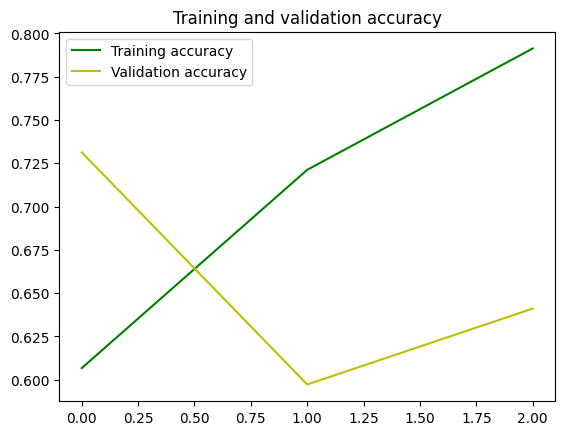

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Sample Prediction

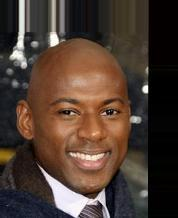

In [13]:
from PIL import Image
from IPython.display import display

path ="Dataset/Test/Male/160008.jpg"
img = Image.open(path)
display(img)

In [17]:
import numpy as np

from keras.preprocessing import image
#  images test 1
paths = ["Dataset/Test/Male/160008.jpg"]

for item in paths:
    imge = image.load_img(item, target_size=target_size)
    X = image.img_to_array(imge)
    X = np.expand_dims(X, axis=0)

    images = np.vstack([X])
    classes = model.predict(images ,batch_size=1)
    print(classes)
    if classes[0] < 0.5:
        print("This is a female")
    else:
        print( "This  is a male")

1/1 [==============================] - 0s 102ms/step
[[1.]]
This  is a male
